### How to use the RCPANN model
This ipynb file shows how to use the API of the RCPANN model which models the spin-averaged proton flux in the L-shell range of [2.5, 6.5] and in the RBSP/RBSPICE energy range 45 keV - 598 keV. Four examples are also provided to guide users to use this model.<br>
Download all the geomagnetic indices data (symh_sme_20xx.csv), and store them in the dir0 directory. Download all the model data (rcpann_xxx_keV.h5) and store them in the dir0 directory. Then you can run the examples below.<br>
The RCPANN model can reconstruct proton fluxes in the RBSP/RBSPICE energy range, i.e., [45, 598] keV. You need to select an energy channel by setting iek to be a number in the range of [0,13], which corresponds to energies 45 keV to 598 keV<br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import matplotlib as mpl
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # This is to disable GPU

## Load geomagnetic indices from 2012-01-01 to 2018-12-31 (we need the history 
#  of geomagnetic indices to predict particle fluxes)
dir0="C:/Users/Jimmy/OneDrive/Documents/work/lws/rcpann/"
df_symh    = pd.read_csv(dir0+'geomag_2012_2018.csv')
ekArr=['45','55','67','82','99','121','148','181','220','269','328','400','489','598']
models=[]
for i in range(14):
    model = tf.keras.models.load_model(dir0+"ann_model/p_"+ekArr[i]+"_keV.h5")
    models.append(model)
history_length_arr = [6,6,6,10,10,13,10,10,12,10,11,16,14,14]

# iek : 0-13
# coord: L, cos(theta), sin(theta), Lat
#   L: 2.5-6.5; theta: MLT/12; Lat: in units of rad
# tstr: e.g., '2017-03-01 22:42:00'
def rcpann(iek, coord0, input=None, tstr=None):
    coord = coord0.copy()
    
    if (coord.shape[-1]!=4):
        print("the coord should be in shape of (4,) or (, 4)")
        return
    if coord.ndim==1:
        coord = coord.reshape([1,4])
    coord[:,0] = (coord[:,0]-2.5)/(6.57-2.5)*2.0-1.0
    coord[:,3] = coord[:,3]/0.35
    n_coord = coord.shape[0]
    input_para_num = history_length_arr[iek]*48+4
    if tstr is None:
        if (input.ndim != 2 and input.shape[1]!=input_para_num):
            print("Input must be 2-dimensional data in shape of ( , "+str(input_para_num)+")")
            return
    else:
        if tstr is None:
            print("Please set the tstr to be a time between 2012-02-01 and 2018-12-01")
            return
        else:
            indt1_symh=np.where(df_symh['Datetime'] >= tstr)
            indt1_symh=indt1_symh[0][0]
            X_mat = df_symh.iloc[(indt1_symh-history_length_arr[iek]*24*12):(indt1_symh+1):24,11:].to_numpy()

            # Scale geomagnetic indices
            Xlow=np.array([-100.,    0.,    0.,     0.]) #Xmin = symh_ae.min(axis=0), min value over 2012-10-01 ~ 2018-12-31
            Xhig=np.array([  20.,  100.,  100.,  1500.]) #Xmax = symh_ae.max(axis=0)
            for i in range(4):
                X_mat[:,i] = (X_mat[:,i] -Xlow[i])/(Xhig[i]-Xlow[i])*2.0-1.0
            input = X_mat.reshape((-1,input_para_num))
            

    X_1_mat=np.matmul(np.ones([n_coord,1]),input) #n_coord * input_para_num
    X_input=np.concatenate((X_1_mat,coord),axis=1)
    return models[iek].predict(X_input)


In [2]:
# Example 1
# Input: iek, coord in shape of either (4,) or (1,4), and geomag_timeseq in shape of (1,input_para_num)
iek=1
# iek      0     1     2     3     4      5      6      7      8     9      10    11     12     13
# energy '45', '55', '67', '82', '99', '121', '148', '181', '220', '269', '328', '400', '489', '598' keV
input_para_num = history_length_arr[iek]*48+4
geomag_timeseq=tf.random.uniform(shape=[1,input_para_num],minval=-1).numpy()
coord=np.array([3.5, 0.0, 1.0, 0.0]) # L=3.5, cos(theta)=0, sin(theta)=1.0, Lat=0.0, which means MLT = 6h
print( rcpann(iek,coord,input=geomag_timeseq) )



1/1 [==============================] - 0s 70ms/step
[[6.642611]]


In [3]:
# Example 2: predict proton flux at multiple locations
# Coord in shape of (x,4)
geomag_timeseq=tf.random.uniform(shape=[1,input_para_num],minval=-1).numpy()
coord2=np.array([[3.5, 0.0, 1.0, 0.0],[4.5,1.0,0.0,0.0],[5.6,0.707,0.707,0.]]) # L=3.5, cos(theta)=0, sin(theta)=1.0, Lat=0.0, which means MLT = 6h
print( rcpann(iek,coord2,input=geomag_timeseq) )



1/1 [==============================] - 0s 36ms/step
[[6.899558]
 [8.156403]
 [8.379532]]


In [4]:
# Example 3: Predict proton flux at a specific moment
# Input: iek, coord in shape of either (4,) or (1,4), and tstr in form of 'yyyy-mm-dd hh:mm:ss'
print(rcpann(iek,coord,tstr = '2017-03-01 22:42:00'))

#np.set_printoptions(precision=3,suppress=True)


1/1 [==============================] - 0s 14ms/step
[[7.026594]]


In [5]:
# Example 4: calculate the global distribution of proton flux
# This session shows how to use the RCPANN model to produce a global distribution of 
# spin-averaged proton flux at a specific energy, which is stored in "y_pred_matrix". 
# The data y_pred_matrix is the equatorial proton flux in the Xrange of [-6.5, 6.5] 
# and Yrange of [-6.5, 6.5], but only those in the in the radial distance range 
# [2.5, 6.5] are trustful. 

tstr1='2017-03-01 16:42:00'
tstr2='2017-03-04 23:59:00'
indt1_symh=np.where(df_symh['Datetime'] >= tstr1)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] >= tstr2)
indt2_symh=indt2_symh[0][0]+1
tarr_dt=df_symh['Datetime'].astype('datetime64')[indt1_symh:indt2_symh].reset_index(drop=True)

xrange=[-6.5,6.5]
yrange=xrange.copy()
delta = 0.1
NX=int((xrange[1]-xrange[0])/delta)
NY=int((yrange[1]-yrange[0])/delta)
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
XX, YY = np.meshgrid(x, y)

XX_flat=XX.flatten()
YY_flat=YY.flatten()
RR_flat=np.sqrt(XX_flat**2+YY_flat**2)
sint_flat = -YY_flat/RR_flat #Since we defined sint = sin(MLT/12*!pi)
cost_flat = -XX_flat/RR_flat
LAT_flat = XX_flat*0.0

coord_glb=np.concatenate((RR_flat.reshape([-1,1]),cost_flat.reshape([-1,1]),sint_flat.reshape([-1,1]),LAT_flat.reshape([-1,1])), axis=1)
y_pred_matrix=rcpann(iek,coord_glb,tstr = '2017-03-01 22:42:00')


529/529 [==============================] - 0s 545us/step


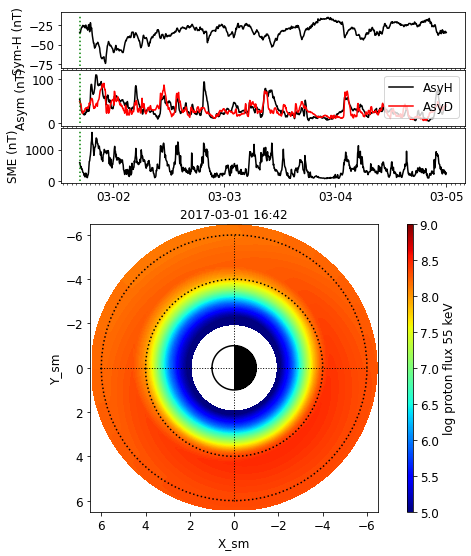

In [6]:
# Visualize the global distribution of ion fluxes
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
X, Y = np.meshgrid(x, y)
vmax=9.0
vmin=5.0
norm = mpl.cm.colors.Normalize(vmax=vmax, vmin=vmin)
cmap = mpl.cm.jet

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

ax_x0=0.2
ax_dx=0.7
ax_dy=0.10
ax_dy_1=0.097
ax_y0=0.55

k=0

tbar=tarr_dt[k]
fig4=plt.figure(figsize=(8,8),facecolor='white')   

n_fig=4
#fig = plt.figure(figsize=(18, 14),facecolor='white')   
fs_label=12
fs_major=12
fs_minor=9

ax1=fig4.add_subplot(n_fig,1,1)
ax1.set_position([ax_x0,ax_y0+3*ax_dy,ax_dx,ax_dy_1])
ax1.plot(tarr_dt,df_symh['SymH'][indt1_symh:indt2_symh],'k')
y_min, y_max = ax1. get_ylim()
ax1.plot([tbar,tbar],[y_min,y_max],':g')
ax1.set_ylabel("Sym-H (nT)",fontsize=fs_label)
ax1.tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off

ax1.xaxis.set_major_locator(mpl.dates.DayLocator())
ax1.xaxis.set_minor_locator(mpl.dates.HourLocator())
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
ax1.tick_params(axis='both', which='major', labelsize=fs_major)
ax1.tick_params(axis='both', which='minor', labelsize=fs_minor)

ax2=fig4.add_subplot(n_fig,1,2)
ax2.set_position([ax_x0,ax_y0+2*ax_dy,ax_dx,ax_dy_1])
ax2.plot(tarr_dt,df_symh['AsyH'][indt1_symh:indt2_symh],'k')
ax2.plot(tarr_dt,df_symh['AsyD'][indt1_symh:indt2_symh],'r')
y_min, y_max = ax2. get_ylim()
ax2.plot([tbar,tbar],[y_min,y_max],':g')
ax2.set_ylabel("Asym (nT)",fontsize=fs_label)
ax2.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off

ax2.xaxis.set_major_locator(mpl.dates.DayLocator())
ax2.xaxis.set_minor_locator(mpl.dates.HourLocator())
ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
ax2.tick_params(axis='both', which='major', labelsize=fs_major)
ax2.tick_params(axis='both', which='minor', labelsize=fs_minor)
ax2.legend(('AsyH', 'AsyD'), loc='upper right',fontsize=fs_label)

ax3=fig4.add_subplot(n_fig,1,3)
ax3.set_position([ax_x0,ax_y0+1*ax_dy,ax_dx,ax_dy_1])
ax3.plot(tarr_dt,df_symh['SME'][indt1_symh:indt2_symh],'k')
y_min, y_max = ax3. get_ylim()
ax3.plot([tbar,tbar],[y_min,y_max],':g')
ax3.set_ylabel("SME (nT)",fontsize=fs_label)

ax3.xaxis.set_major_locator(mpl.dates.DayLocator())
ax3.xaxis.set_minor_locator(mpl.dates.HourLocator())
ax3.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
ax3.tick_params(axis='both', which='major', labelsize=fs_major)
ax3.tick_params(axis='both', which='minor', labelsize=fs_minor)

#Subfigure 4

y_pred_matrix=y_pred_matrix[:,0].reshape([NX,NY])

ax0=fig4.add_subplot(5,1,5)
ax0.set_position([0.25,0.08,0.5,0.5])
im = ax0.contourf(X, Y, y_pred_matrix,  256,cmap=mpl.cm.jet,vmax=vmax,vmin=vmin)

#Set L>6.5 and L<2 blank
theta2=np.arange(0,2.01*np.pi,0.02)
r2=np.arange(6.5,9.5,0.1)
R,THETA=np.meshgrid(r2,theta2)
X2=R*np.cos(THETA)
Y2=R*np.sin(THETA)
im3=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
r2=np.arange(0.0,2.0,0.1)
R,THETA=np.meshgrid(r2,theta2)
X2=R*np.cos(THETA)
Y2=R*np.sin(THETA)
im4=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)

#Add Earth
theta=np.arange(0,2.01*np.pi,0.1)
ax0.plot(np.cos(theta),np.sin(theta),'k')
r=np.arange(0,1.1,0.1)
theta1=np.arange(0.5*np.pi,1.5*np.pi,0.02)
R,THETA=np.meshgrid(r,theta1)
X1=R*np.cos(THETA)
Y1=R*np.sin(THETA)
im2=ax0.contourf(X1,Y1,X1*0+0.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
#Add 0, 6, 12, 18 sectors and L=4,6
ax0.plot([-6,6],[0,0],':k',linewidth=1)
ax0.plot([0,0],[-6,6],':k',linewidth=1)
ax0.plot(6*np.cos(theta),6*np.sin(theta),':k')
ax0.plot(4*np.cos(theta),4*np.sin(theta),':k')

#ax0.set_title('Proton 7.1 keV',fontsize=20)
ax0.set_xlabel("X_sm",fontsize=fs_label)
ax0.set_ylabel("Y_sm",fontsize=fs_label)
ax0.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax0.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax0.tick_params(axis='both', which='major', labelsize=fs_label)
ax0.tick_params(axis='both', which='minor', labelsize=fs_label)
plt.axis('equal')
ax0.set_xlim([-6.5,6.5])
ax0.set_ylim(-6.5,6.5)
ax0.invert_xaxis()
ax0.invert_yaxis()

# Add colorbar
cax = plt.axes([0.8, 0.08, 0.01, 0.5])
cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0,cax=cax)
cbar.ax.tick_params(labelsize=fs_label)
cbar.set_label('log proton flux '+ekArr[iek]+' keV', fontsize=fs_label)
ax0.set_title(tbar.strftime("%Y-%m-%d %H:%M"),fontsize=fs_label)
plt.show()
